# Conversation-Connect
### Identifying patients for Serious Illness Conversations

> Corey Chivers, PhD <corey.chivers@pennmedicine.upenn.edu> <br>
> Copyright (c) 2019 University of Pennsylvania Health System, MIT License

Predict risk of 6 month mortality for a general population of Penn Medicine Oncology adult patients to improve access to advanced care planning for those most likely to benefit.

In [1]:
%pylab inline

import pandas as pd
import ps_analysis_utils
import pickle

pd.set_option('display.max_columns', 10000)
pd.set_option('display.max_rows', 10000)

Populating the interactive namespace from numpy and matplotlib


In [2]:
enc_data = pd.read_csv('../data/OutpatientONC_v1_1_enc_data_features.csv')

/Users/cchivers/anaconda2/envs/eol_paper/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
enc_data['DEATH_DATE'] = pd.to_datetime(enc_data['DEATH_DATE'])
enc_data['APPT_TIME'] = pd.to_datetime(enc_data['APPT_TIME'])

In [4]:
res2 = enc_data

In [5]:
np.random.seed(123456)

## Randomly sample one encounter per EMPI
idx = list(res2.index)
np.random.shuffle(idx)
res2 = res2.iloc[idx,:].drop_duplicates('EMPI')
##

label_name = 'label'

res2.index = range(res2.shape[0])
EMPIs = res2['EMPI'].unique()

prop_train = 0.7
n_train = int(len(EMPIs) * prop_train)

print(n_train, len(EMPIs) - n_train)

np.random.shuffle(EMPIs)
train_empis = EMPIs[:n_train]
test_empis = EMPIs[n_train:]
train_idx = res2['EMPI'].isin(train_empis)
test_idx = res2['EMPI'].isin(test_empis)

train = res2[train_idx]
test = res2[test_idx]

train_idx.sum(), test_idx.sum()

18567 7958


(18567, 7958)

In [6]:
train[label_name].mean(), test[label_name].mean(), 

(0.0385091829590133, 0.04398089972354863)

In [7]:
train[label_name].sum(), test[label_name].sum(), 

(715, 350)

# Feature Selection

In [8]:
num_cols = [c for c in enc_data if ': ' in c]
dx_cols = [c for c in enc_data if c.startswith('n_')]
cat_cols = [c for c in enc_data if '>>>' in c]

In [9]:
feature_cols = dx_cols + num_cols + cat_cols + ['PAT_AGE','SEX_C']

In [10]:
in_vars = feature_cols
len(in_vars)

766

Remove variables with zero variance

In [11]:
var = train[in_vars].var()
zero_variance_vars = list(var[var == 0.0].index)
zero_variance_vars

['POC Glucose (Fingerstick): prop STAT ordered',
 'VSS Fractions Prescribed: prop STAT ordered',
 'VSS Total Dose Limit: prop STAT ordered',
 'VSS Dose Given To Date: prop STAT ordered',
 'VSS Fractions Treated: prop STAT ordered',
 'Ventricular Rate: prop STAT ordered',
 'R Axis: prop STAT ordered',
 'QRS Duration: prop STAT ordered',
 'T Axis: prop STAT ordered',
 'Q-T Interval: prop STAT ordered',
 'QTC Calculation(Bazett): prop STAT ordered',
 'Atrial Rate: prop STAT ordered',
 'P-R Interval: prop STAT ordered',
 'P Axis: prop STAT ordered',
 'pCO2 Art: prop STAT ordered']

In [12]:
# Drop zero variance features
in_vars = [v for v in in_vars if v not in zero_variance_vars]
len(in_vars)

751

### Group Highly correlated Features

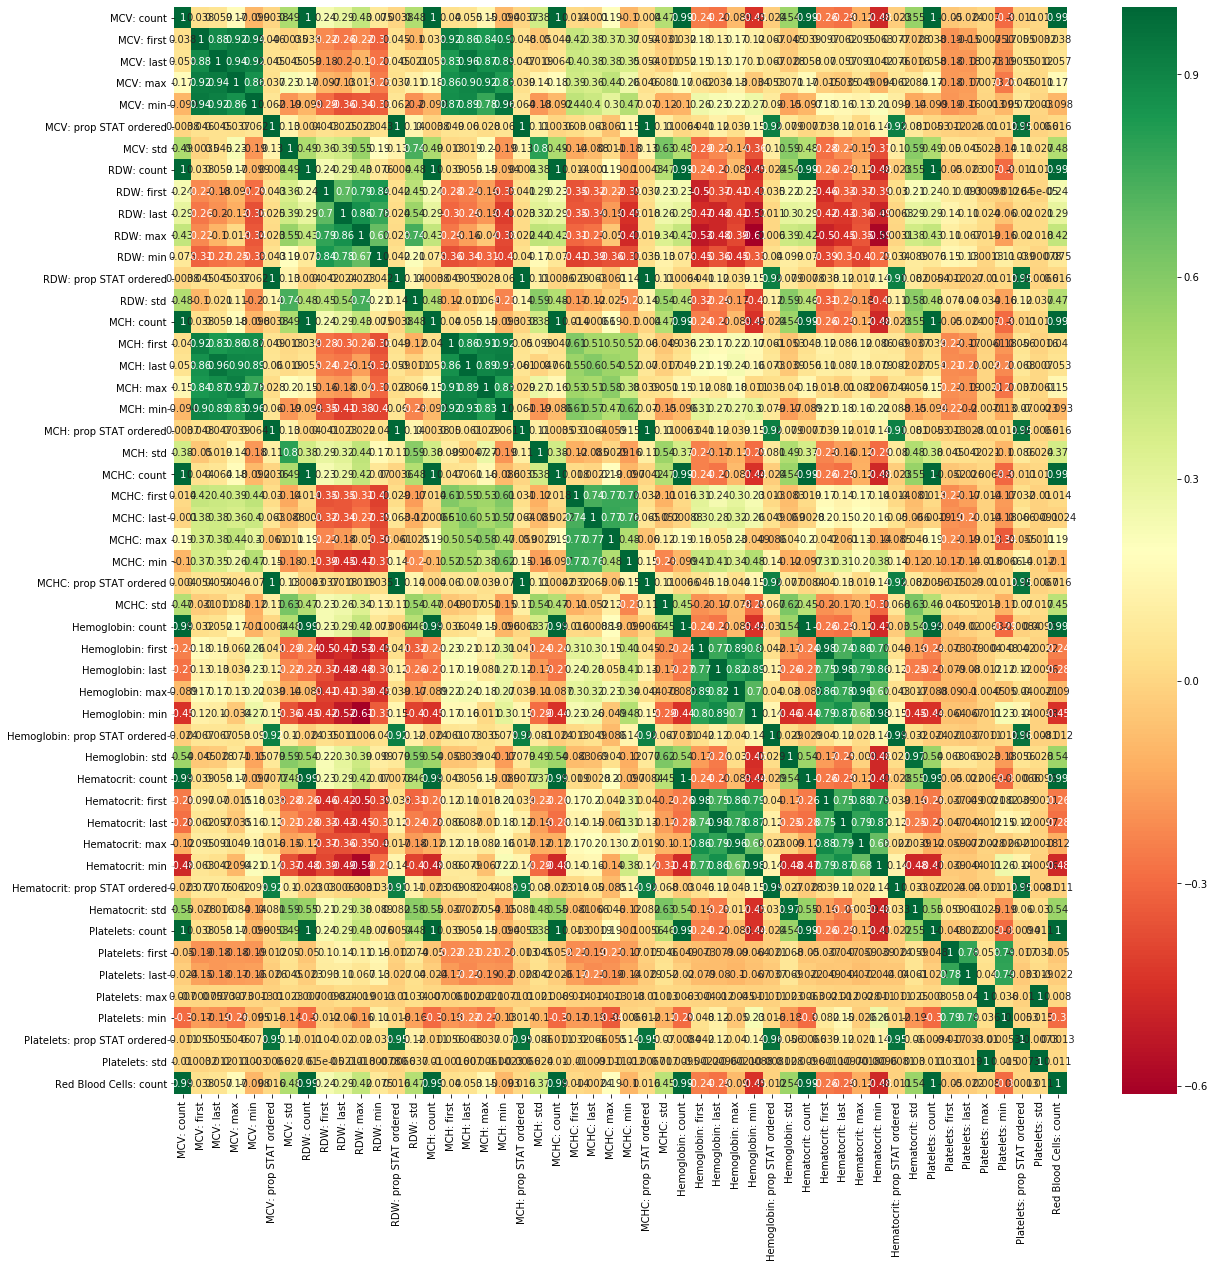

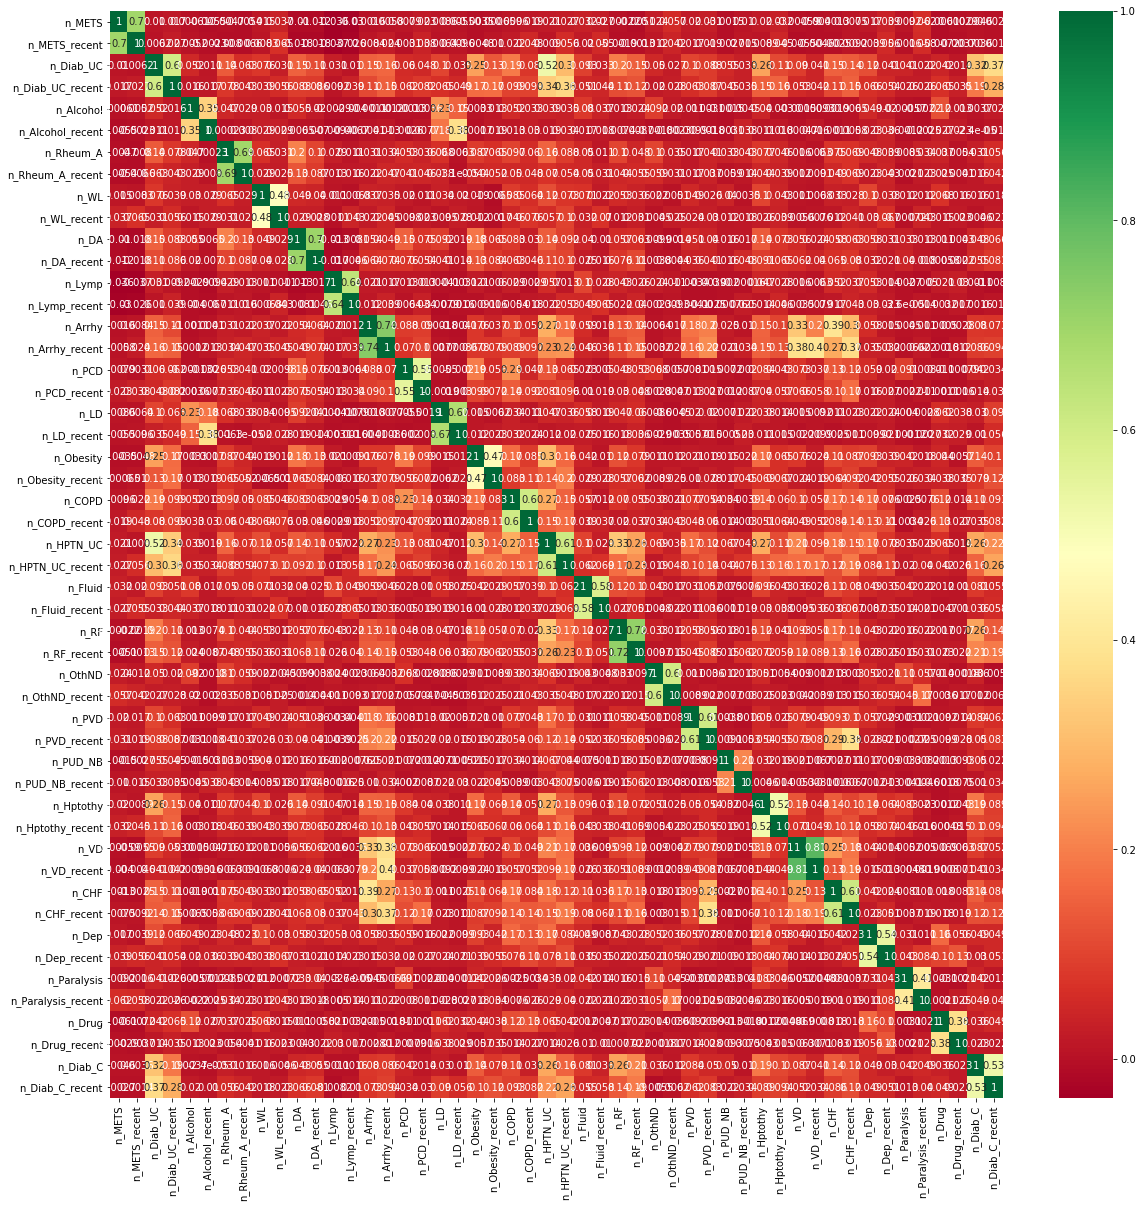

In [20]:
import seaborn as sns

plt.figure(figsize=(20,20))
g=sns.heatmap(train[num_cols[:50]].corr(),annot=True,cmap="RdYlGn")

plt.figure(figsize=(20,20))
g=sns.heatmap(train[dx_cols[:50]].corr(),annot=True,cmap="RdYlGn")

In [21]:
# drop correlated features, retain a map of redundancy
CORRELATION_THRESHOLD = 0.95

grouped = []
grouped_dict = {}
cor_map = train[in_vars].corr()
for var in cor_map.index:
    if var not in grouped:
        cor_vec = cor_map.loc[var,:]
        idb_cor =  cor_vec > CORRELATION_THRESHOLD
        collected = list(cor_vec[idb_cor].index)
        collected = [c for c in collected if c != var]
        grouped.extend(collected)
        grouped_dict.update({var: collected})

In [22]:
grouped_dict = {k:v for k,v in grouped_dict.items() if len(v)>0}
grouped_dict

{'MCV: count': ['RDW: count',
  'MCH: count',
  'MCHC: count',
  'Hemoglobin: count',
  'Hematocrit: count',
  'Platelets: count',
  'Red Blood Cells: count',
  'Creatinine: count',
  'White Blood Cells: count',
  'Sodium: count',
  'Urea Nitrogen: count',
  'Chloride: count',
  'Potassium: count',
  'Anion Gap: count',
  'Carbon Dioxide: count',
  'Glucose: count',
  'Calcium: count'],
 'MCV: last': ['MCH: last'],
 'MCV: min': ['MCH: min'],
 'MCV: prop STAT ordered': ['RDW: prop STAT ordered',
  'MCH: prop STAT ordered',
  'MCHC: prop STAT ordered',
  'Platelets: prop STAT ordered'],
 'Hemoglobin: first': ['Hematocrit: first'],
 'Hemoglobin: last': ['Hematocrit: last'],
 'Hemoglobin: max': ['Hematocrit: max'],
 'Hemoglobin: min': ['Hematocrit: min'],
 'Hemoglobin: prop STAT ordered': ['Hematocrit: prop STAT ordered',
  'Platelets: prop STAT ordered'],
 'Hemoglobin: std': ['Hematocrit: std'],
 'Platelets: max': ['Platelets: std'],
 'Red Blood Cells: max': ['Red Blood Cells: std'],
 'Re

In [23]:
in_vars = [v for v in in_vars if v not in grouped]
len(in_vars)

590

### Mutual information criteria

In [24]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

In [25]:
bestfeatures = SelectKBest(score_func=mutual_info_classif, k=10)

In [26]:
fit = bestfeatures.fit(train[in_vars], train['label'])
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(train[in_vars].columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['var','score']
print(featureScores.nlargest(10,'score'))

                           var     score
220              Albumin: last  0.021383
222               Albumin: min  0.020670
76                    MCH: std  0.019989
160                   AST: std  0.019219
71                    RDW: max  0.018481
169  Alkaline Phosphatase: max  0.018480
73                    RDW: std  0.018273
111                Sodium: min  0.017735
133             Anion Gap: std  0.017553
196         % Lymphocytes: min  0.017310


In [27]:
#drop those with no mutual information
zero_mutual_info_vars = featureScores[featureScores['score'] == 0.0]['var'].values
zero_mutual_info_vars

array(['n_Diab_UC', 'n_DA_recent', 'n_Obesity_recent', 'n_RF',
       'n_VD_recent', 'n_Diab_C_recent', 'n_BLA_recent', 'n_HIV_recent',
       'n_HPTN_C_recent', '# Atypical Lymphocytes: last',
       '% Lymph Variants: first', '% Lymph Variants: max',
       '# Basophils Manual: min',
       'LACTATE DEHYDROGENASE: prop STAT ordered',
       'LACTIC ACID: prop STAT ordered',
       'IMMUNOGLOBULIN G: prop STAT ordered', 'IMMUNOGLOBULIN G: std',
       'IMMUNOGLOBULIN M: std', 'IMMUNOGLOBULINS A: std',
       'Albumin Fraction: prop STAT ordered', 'RETICULOCYTE COUNT: count',
       'RETICULOCYTE COUNT: prop STAT ordered',
       'Total Cholesterol: first', 'Total Cholesterol: prop STAT ordered',
       'Total Cholesterol: std', 'Alpha1-Globulin Frac: first',
       'Alpha1-Globulin Frac: last', 'Alpha1-Globulin Frac: min',
       'Alpha1-Globulin Frac: std',
       'TACROLIMUS (FK506): prop STAT ordered',
       'SPECIALTY >>> Hematology/Oncology'], dtype=object)

In [28]:
in_vars = [v for v in in_vars if v not in zero_mutual_info_vars]
len(in_vars)

559

In [30]:
def cumulative_importance_plot(importances, top_n=100):
    imp = importances.sort_values('importance',ascending=False).copy()
    imp.index = range(imp.shape[0])
    imp['cumulative_prop'] = imp['importance'].cumsum()/imp['importance'].sum()
    
    if top_n is None:
        top_n = imp.shape[0]
    fig, ax = plt.subplots(1,1,figsize=(20,5))
    
    ax.bar(range(min(top_n,imp.shape[0])), imp['importance'].head(top_n).values)
    ax.set_xticks(range(top_n))
    ax.set_ylabel('Importance')
    
    ax2 = ax.twinx()
    ax2.plot(imp['cumulative_prop'].head(top_n),color='red')
    ax2.set_xticks(range(top_n))
    ax2.set_ylabel('Cummulative Proportional\nImportance')
    
    ax.set_xticklabels(imp['var'].head(top_n),rotation=90)
    plt.show()
    return imp

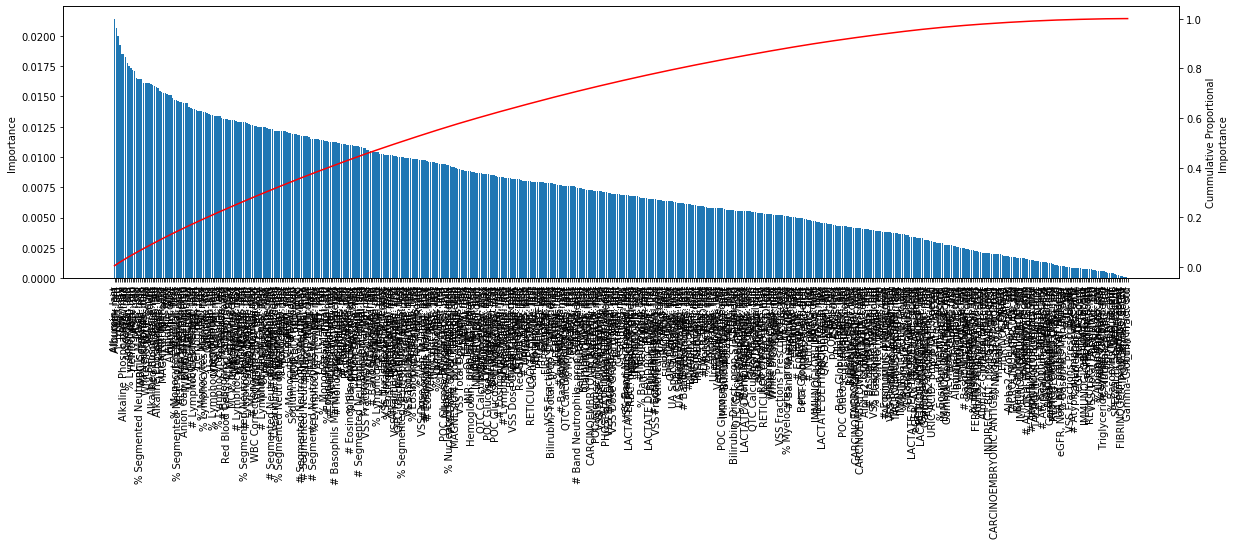

In [36]:
featureScores_as_importance = featureScores[featureScores['score'] != 0.0].copy()
featureScores_as_importance.columns = ['var','importance']
imp = cumulative_importance_plot(featureScores_as_importance, len(in_vars))

In [37]:
imp.head()

,var,importance,cumulative_prop
0,Albumin: last,0.021383,0.005190
1,Albumin: min,0.020670,0.010208
2,MCH: std,0.019989,0.015060
3,AST: std,0.019219,0.019724
4,RDW: max,0.018481,0.024210


In [38]:
imp.tail()

,var,importance,cumulative_prop
554,Total Cholesterol: count,0.000172,0.999926
555,FIBRINOGEN: prop STAT ordered,0.000129,0.999958
556,Triglycerides: count,0.000091,0.999980
557,n_Psych_recent,0.000061,0.999995
558,Gamma-Globulin Fract: std,0.000022,1.000000


# Final Features Selected

In [39]:
len(in_vars)

559

In [40]:
in_vars

['n_METS',
 'n_METS_recent',
 'n_Diab_UC_recent',
 'n_Alcohol',
 'n_Alcohol_recent',
 'n_Rheum_A',
 'n_Rheum_A_recent',
 'n_WL',
 'n_WL_recent',
 'n_DA',
 'n_Lymp',
 'n_Lymp_recent',
 'n_Arrhy',
 'n_Arrhy_recent',
 'n_PCD',
 'n_PCD_recent',
 'n_LD',
 'n_LD_recent',
 'n_Obesity',
 'n_COPD',
 'n_COPD_recent',
 'n_HPTN_UC',
 'n_HPTN_UC_recent',
 'n_Fluid',
 'n_Fluid_recent',
 'n_RF_recent',
 'n_OthND',
 'n_OthND_recent',
 'n_PVD',
 'n_PVD_recent',
 'n_PUD_NB',
 'n_PUD_NB_recent',
 'n_Hptothy',
 'n_Hptothy_recent',
 'n_VD',
 'n_CHF',
 'n_CHF_recent',
 'n_Dep',
 'n_Dep_recent',
 'n_Paralysis',
 'n_Paralysis_recent',
 'n_Drug',
 'n_Drug_recent',
 'n_Diab_C',
 'n_Coag',
 'n_Coag_recent',
 'n_BLA',
 'n_Tumor',
 'n_Tumor_recent',
 'n_HIV',
 'n_HPTN_C',
 'n_Psych',
 'n_Psych_recent',
 'MCV: count',
 'MCV: first',
 'MCV: last',
 'MCV: max',
 'MCV: min',
 'MCV: prop STAT ordered',
 'MCV: std',
 'RDW: first',
 'RDW: last',
 'RDW: max',
 'RDW: min',
 'RDW: std',
 'MCH: first',
 'MCH: max',
 'MCH: st

In [41]:
with open('../models/in_vars.p','wb') as f:
    pickle.dump(in_vars, f, pickle.HIGHEST_PROTOCOL)

At this point, the selected features are used to build the models using random grid search for hyperparameter optimization.

### Build & Run

Replace `/data/eol/eol-onc/` with the path to this project and run the following:

```bash
docker build -t eol .
docker run -d --rm -it -v /data/eol/eol-onc/:/data eol /bin/bash
```

### Training

Connect to the running container by finding the container name with `docker ps`

```bash
docker exec -it <container name> /bin/bash
```

In the container, spin up training jobs with:
```bash
cd /data
source activate eol_paper
nohup python3 EoL_model_ONC_v1_2.py -f data/OutpatientONC_v1_1_enc_data_features.csv --n-iter 100 --k-cv 5 -m rf > rf_gs.out &
disown %1

nohup python3 EoL_model_ONC_v1_2.py -f data/OutpatientONC_v1_1_enc_data_features.csv --n-iter 100 --k-cv 5 -m gb > gb_gs.out &
disown %1
```

Download the resulting model files for evaluation.

# Evaluation

In [27]:
from sklearn import metrics

def binary_cv_metrics(y, preds, m):
    ACC = metrics.accuracy_score(y,preds)
    cm = metrics.confusion_matrix(y,preds)
    if y.mean() == 0:
        cm = np.array([[np.logical_not(preds).sum(),preds.sum()],[0,0]])
        ACC = np.logical_not(preds).mean()
    elif y.mean() == 1:
        cm = np.array([[0,0],[np.logical_not(preds).sum(),preds.sum()]])
        ACC = preds.mean()
        
    m['confusion_matrix'] = cm
    m['Accuracy'] = ACC
    m['base rate'] = y.mean()
    m['n'] = cm.sum()
    m['F1 score'] = metrics.f1_score(y,preds)
    m['FPR'] = cm[0,1]/(cm[0,:].sum()*1.0)
    m['FNR'] = cm[1,0]/(cm[1,:].sum()*1.0)
    m['Alert Rate'] = cm[:,1].sum()*1.0 / cm.sum()
    m['Specificity (TNR)'] = cm[0,0]/(cm[0,:].sum()*1.0)
    m['Sensitivity (TPR, Recall)'] = cm[1,1]/(cm[1,:].sum()*1.0)
    m['PPV (Precision)'] = cm[1,1]/(cm[:,1].sum()*1.0)
    m['NPV'] = cm[0,0]/(cm[:,0].sum()*1.0)

def cv_metrics(y,probas,m,threshold=0.5):
    '''Collect performance metrics'''
    preds = probas >= threshold

    fpr, tpr, thresholds = metrics.roc_curve(y, probas)
    try:
        AUC = metrics.auc(fpr, tpr)
        m['AUC'] = AUC
    except:
        m['AUC'] = np.nan
        
    binary_cv_metrics(y, preds, m)

In [28]:
def plot_perf(clf, in_vars, test,label_name='label',plt_cal=True, logistic=False):  
    if logistic:
        test['Pred'] = result.predict(test[in_vars])
    else:
        test['Pred'] = clf.predict_proba(test[in_vars])[:,1]

    preds = test['Pred'].values
    preds = np.array([preds,preds]).T
    ms = []
    threshes = np.linspace(0,test['Pred'].max(),100)
    for thresh in threshes:
        m = {}
        criteria = test['Pred'] > thresh
        binary_cv_metrics(test[label_name],criteria ,m)
        m['threshold'] = thresh
        ms.append(m)
    ms_df = pd.DataFrame(ms)

    fig, ax = plt.subplots(2,1,figsize=(8,8))
    for metric in ['F1 score','NPV','PPV (Precision)','Sensitivity (TPR, Recall)','Specificity (TNR)']:
        ax[0].plot(threshes,ms_df[metric],'-',label=metric)
    ax[0].legend(loc=0)

    ps_analysis_utils.plt_auc(preds,test[label_name],ax=ax[1])
    
    if plt_cal:
        ps_analysis_utils.plot_calibration_curve_error_bars(test[label_name],test['Pred'],n_bins=10)
    
    plt.show()
    importances = None
    if not logistic:
        importances = pd.DataFrame([{'importance':m,'var':in_vars[e]} for e,m in enumerate(clf.feature_importances_)])
        importances = importances.sort_values('importance',ascending=False)
    return importances, ms_df



## Random Forest

In [44]:
with open('../models/rf_random_search.p','rb') as f:
    rf_random = pickle.load(f)

In [45]:
clf = rf_random.best_estimator_

In [46]:
clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=65, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=577,
                       n_jobs=None, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [47]:
clf.oob_score_

0.9618139710238596

/Users/cchivers/anaconda2/envs/eol_paper/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/cchivers/anaconda2/envs/eol_paper/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/cchivers/anaconda2/envs/eol_paper/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


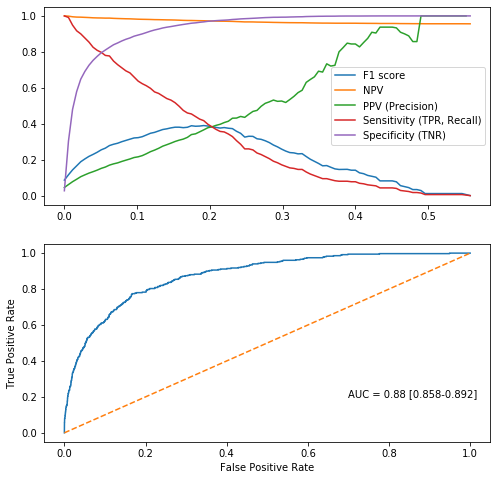

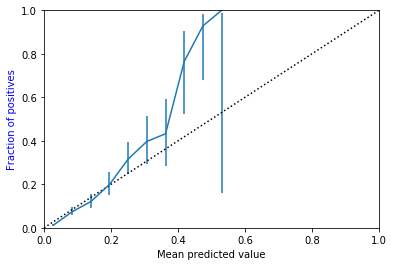

,importance,var
288,0.013120,Albumin: last
290,0.011661,Albumin: min
1,0.011121,n_METS_recent
211,0.011028,Alkaline Phosphatase: last
764,0.009479,PAT_AGE
55,0.009123,n_Tumor_recent
0,0.008634,n_METS
54,0.008212,n_Tumor
253,0.007777,% Lymphocytes: last
212,0.007456,Alkaline Phosphatase: max


In [48]:
importances, ms_df = plot_perf(clf, in_vars, test)
importances.sort_values('importance',ascending=False).head(20)

/Users/cchivers/anaconda2/envs/eol_paper/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/cchivers/anaconda2/envs/eol_paper/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/cchivers/anaconda2/envs/eol_paper/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


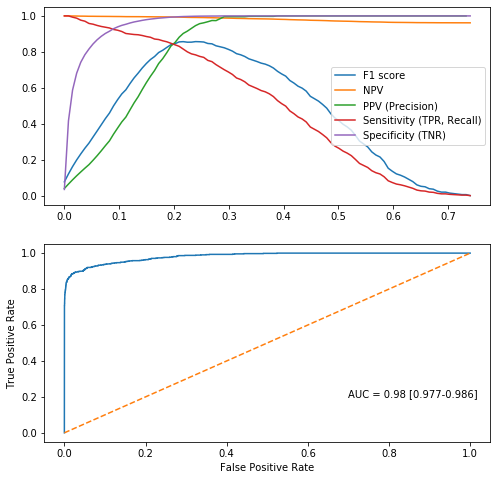

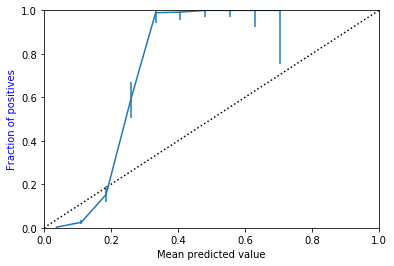

In [38]:
importances, ms_df = plot_perf(clf, in_vars, train)

# Gradient Boosting

In [101]:
with open('../models/gb_random_search.p','rb') as f:
    gb_random = pickle.load(f)
clf = gb_random.best_estimator_
clf

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=10,
                           max_features='auto', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=2, min_samples_split=10,
                           min_weight_fraction_leaf=0.0, n_estimators=366,
                           n_iter_no_change=5, presort='auto', random_state=42,
                           subsample=1.0, tol=0.0001, validation_fraction=0.1,
                           verbose=1, warm_start=False)

/Users/cchivers/anaconda2/envs/eol_paper/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/cchivers/anaconda2/envs/eol_paper/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/Users/cchivers/anaconda2/envs/eol_paper/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/cchivers/anaconda2/envs/eol_paper/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


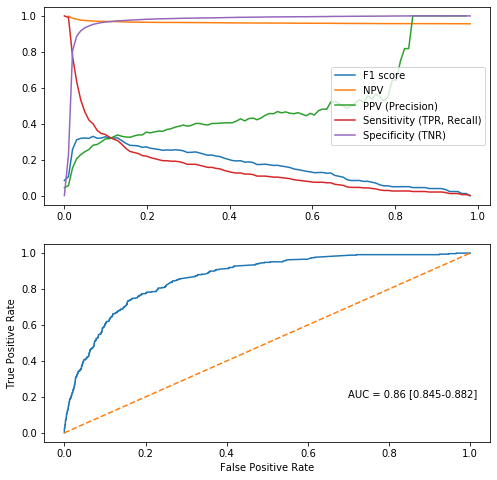

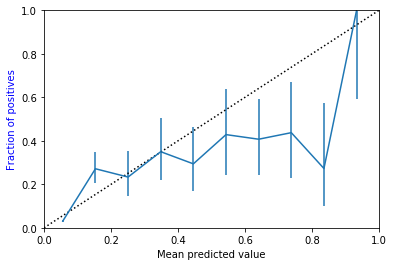

,importance,var
290,0.043885,Albumin: min
288,0.036573,Albumin: last
55,0.025182,n_Tumor_recent
0,0.023136,n_METS
764,0.020326,PAT_AGE
1,0.018435,n_METS_recent
281,0.015410,% Neutrophils: last
211,0.014313,Alkaline Phosphatase: last
106,0.010931,Platelets: last
253,0.010811,% Lymphocytes: last


In [74]:
importances, ms_df = plot_perf(clf, feature_cols, test)
importances.sort_values('importance',ascending=False).head(20)

In [ ]:
importances, ms_df = plot_perf(clf, feature_cols, trail)

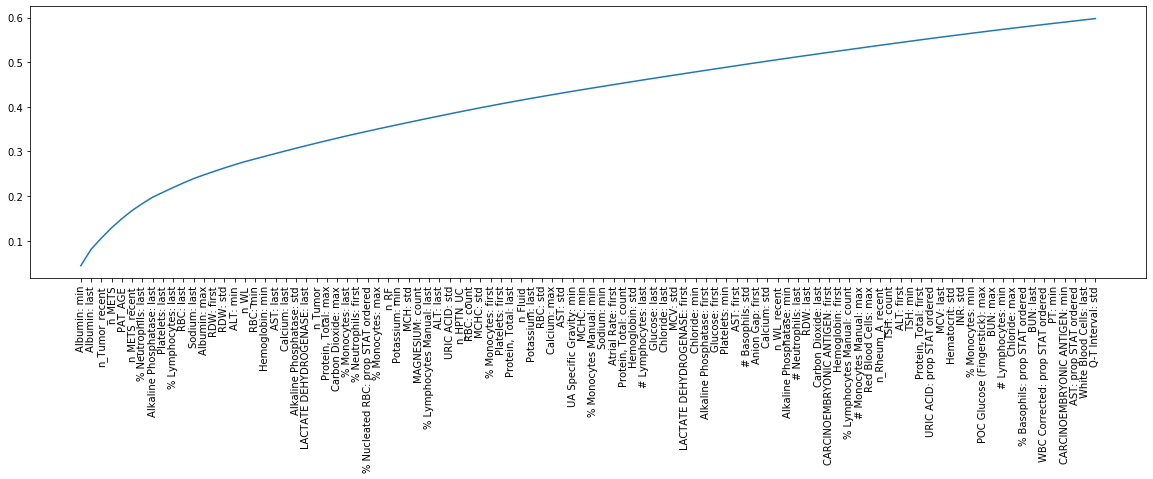

In [75]:
_ = cumulative_importance_plot(importances)

In [43]:
imp = importances.sort_values('importance',ascending=False)
imp[imp['importance'] > 0.0].shape

(545, 2)

In [26]:
ms_df[(ms_df['threshold'] > 0.2) &(ms_df['threshold']<0.22)]

,confusion_matrix,Accuracy,base rate,n,F1 score,FPR,FNR,Alert Rate,Specificity (TNR),"Sensitivity (TPR, Recall)",PPV (Precision),NPV,threshold
21,"[[17816, 36], [153, 562]]",0.989821,0.038509,18567,0.856055,0.002017,0.213986,0.032208,0.997983,0.786014,0.939799,0.991485,0.202374
22,"[[17819, 33], [155, 560]]",0.989875,0.038509,18567,0.856269,0.001849,0.216783,0.031938,0.998151,0.783217,0.944351,0.991376,0.212011


/Users/cchivers/anaconda2/envs/eol_paper/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
/Users/cchivers/anaconda2/envs/eol_paper/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


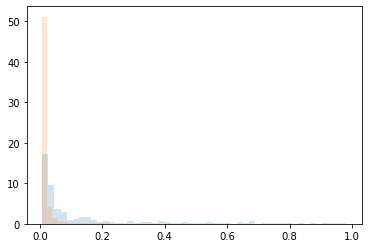

In [27]:
fig, ax = plt.subplots(1,1)
ax.hist(test[test['label'] == 1]['Pred'].values,bins=50,alpha=0.2,normed=True)
ax.hist(test[test['label'] == 0]['Pred'].values,bins=50,alpha=0.2,normed=True);
plt.show()

In [5]:
#test['PROVIDER_NAME'].value_counts()

In [4]:
#test.sort('Pred').tail(20)

subpopulation analysis for  SPECIALTY : ['Hematology/Oncology' 'Oncology']


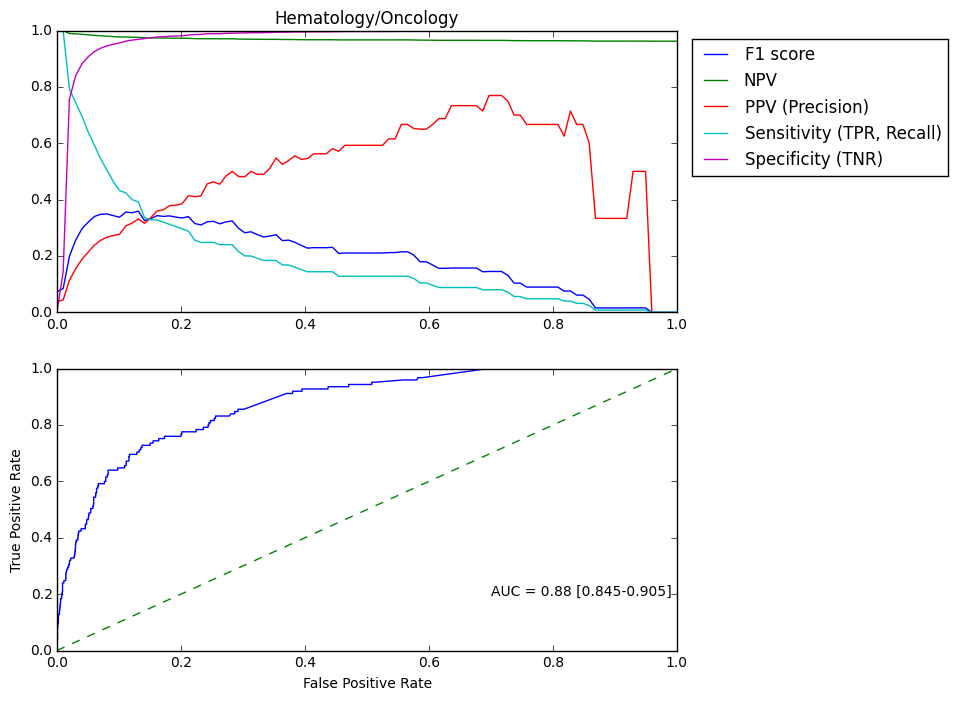

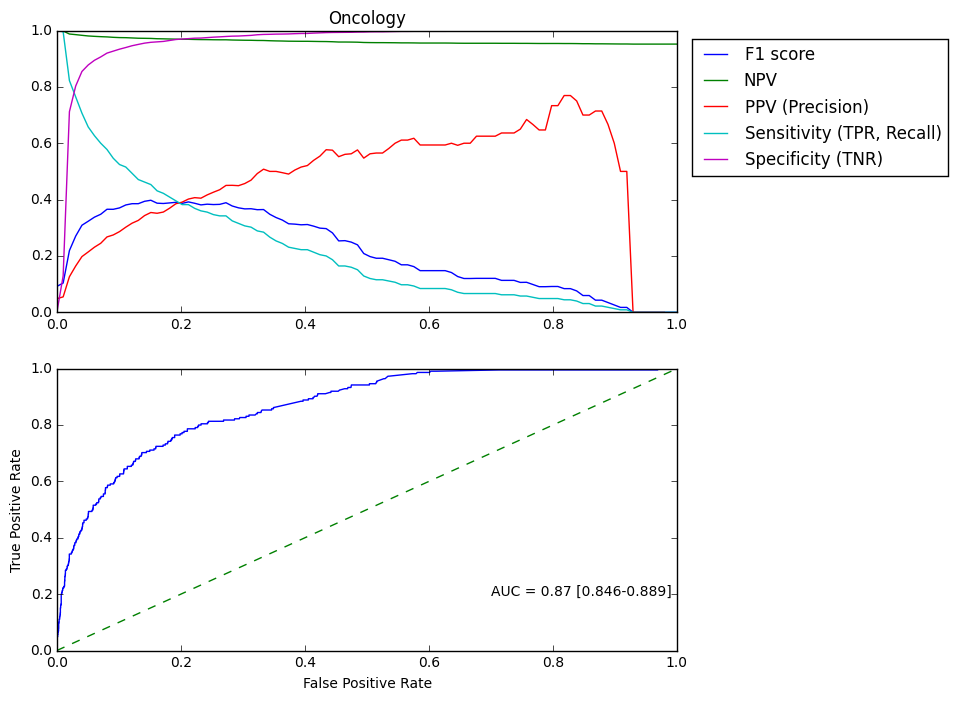

,AUC,Accuracy,Alert Rate,F1 score,FNR,FPR,NPV,PPV (Precision),"Sensitivity (TPR, Recall)",Specificity (TNR),base rate,confusion_matrix,n,threshold
Hematology/Oncology,0.876217,0.9553869,0.02913505,0.3348416,0.704,0.01861199,0.9724914,0.3854167,0.296,0.981388,0.03793627,"[[3111, 59], [88, 37]]",3295,0.2020202
Oncology,0.8680707,0.941454,0.04717993,0.3865169,0.6177778,0.03019378,0.9687148,0.3909091,0.3822222,0.9698062,0.0482522,"[[4304, 134], [139, 86]]",4663,0.2020202


In [27]:
def plt_performance(df,plot_output=True,plt_title=''):
    preds = df['Pred'].values
    preds = np.array([preds,preds]).T
    ms = []
    threshes = np.linspace(0,1,100)
    for thresh in threshes:
        m = {}
        #criteria = df['Pred'] > thresh
        cv_metrics(df[label_name],df['Pred'],m,thresh)
        #m[dx_class] = n
        m.update({'threshold':thresh})
        ms.append(m)
    ms_df = pd.DataFrame(ms)
    
    if plot_output:
        fig, ax = plt.subplots(2,1,figsize=(8,8))
        for metric in ['F1 score','NPV','PPV (Precision)','Sensitivity (TPR, Recall)','Specificity (TNR)']:
            ax[0].plot(threshes,ms_df[metric],'-',label=metric)
        ax[0].legend(bbox_to_anchor=(1.45, 1.0))
        ax[0].set_title(plt_title)
        try:
            ps_analysis_utils.plt_auc(preds,df[label_name],ax=ax[1])
        except:
            pass
        plt.show()
    return ms_df


def run_categorical_subpop(df,category_var,plot_output=True,thresh=0.5):
    m_list = []
    categories = df[category_var].unique()
    print('subpopulation analysis for ',category_var, ':',categories)
    for category in categories:
        idb = df[category_var] == category
        subpop = df[idb]
        if subpop[label_name].sum() == 0 or idb.sum() < 5:
            ms_df = plt_performance(subpop,False,plt_title=category)
            #m = pd.DataFrame([{'n':idb.sum(),'base rate':0.0}])
        else:
            ms_df = plt_performance(subpop,plot_output,plt_title=category)
        m = pd.DataFrame(ms_df.iloc[np.argmin(np.abs(ms_df['threshold'] - thresh))]).T
        m.index = [category]
        m_list.append(m)
    return pd.concat(m_list)


def run_numerical_subpop(df,category_var,plot_output=True,thresh=0.5):
    m_list = []
    categories = []
    n_tiles = 10
    n_tile = np.linspace(0,1,n_tiles)
    n_tile = list(df[category_var].quantile(n_tile))
    for t in range(n_tiles-1):
        idb = (df[category_var] > n_tile[t]) & (df[category_var] <= n_tile[t+1])
        categories.append({'range': "%0.0f-%0.0f"%(n_tile[t],n_tile[t+1]),
                          'idb': idb})
    
    print('subpopulation analysis for ',category_var, ':',[c['range'] for c in categories])
    for category in categories:
        idb = category['idb']
        subpop = df[idb]
        if subpop[label_name].sum() == 0 or idb.sum() < 5:
            m = pd.DataFrame([{'n':idb.sum(),'base rate':0.0}])
        else:
            ms_df = plt_performance(subpop,plot_output,plt_title=category['range'])
            m = pd.DataFrame(ms_df.iloc[np.argmin(np.abs(ms_df['threshold'] - thresh))]).T
        m.index = [category['range']]
        m_list.append(m)
    return pd.concat(m_list)

#sp_age = run_numerical_subpop(test,'SPECIALTY',plot_output=False,thresh=0.3)
sp_specialty = run_categorical_subpop(test,'SPECIALTY',thresh=0.2)
sp_specialty

In [28]:
sp_specialty.T

,Hematology/Oncology,Oncology
AUC,0.876217,0.8680707
Accuracy,0.9553869,0.941454
Alert Rate,0.02913505,0.04717993
F1 score,0.3348416,0.3865169
FNR,0.704,0.6177778
FPR,0.01861199,0.03019378
NPV,0.9724914,0.9687148
PPV (Precision),0.3854167,0.3909091
"Sensitivity (TPR, Recall)",0.296,0.3822222
Specificity (TNR),0.981388,0.9698062


In [29]:
from ps_datasci.psUtilities import buffer_ylim, buffer_xlim

def plt_subpop_perf(df,title='Subgroup Performance',xlabel=''):
    first_plot_items = ['AUC','Accuracy','PPV (Precision)','Sensitivity (TPR, Recall)','Specificity (TNR)']
    second_plot_items = ['base rate']
    third_plot_items = ['n']
    fig, axx = plt.subplots(3,1, sharex=True,figsize=(8,8))
    ax = axx[0]
    ax.set_title(title)
    for fp_item in first_plot_items:
        ax.plot(df[fp_item],'.-',label=fp_item)
    ax.legend(bbox_to_anchor=(1.6, 1.0))
    ax.grid()
    buffer_ylim(ax,0.1)
    
    ax = axx[1]
    for fp_item in second_plot_items:
        ax.plot(df[fp_item],'.-',label=fp_item)
    ax.legend(bbox_to_anchor=(1.35, 1.0))
    ax.grid()
    buffer_ylim(ax,0.1)
    
    ax = axx[2]
    for fp_item in third_plot_items:
        ax.plot(df[fp_item],'.-',label=fp_item)
    ax.legend(loc='upper right',bbox_to_anchor=(1.2, 1.0))
    ax.set_xticks(range(df.shape[0]))
    ax.set_xticklabels(df.index,rotation=45,horizontalalignment='right')
    ax.set_xlabel(xlabel)
    ax.grid()
    buffer_ylim(ax,0.1)
    buffer_xlim(ax,0.05)

subpopulation analysis for  PAT_AGE : ['14-42', '42-51', '51-57', '57-61', '61-65', '65-69', '69-73', '73-79', '79-99']


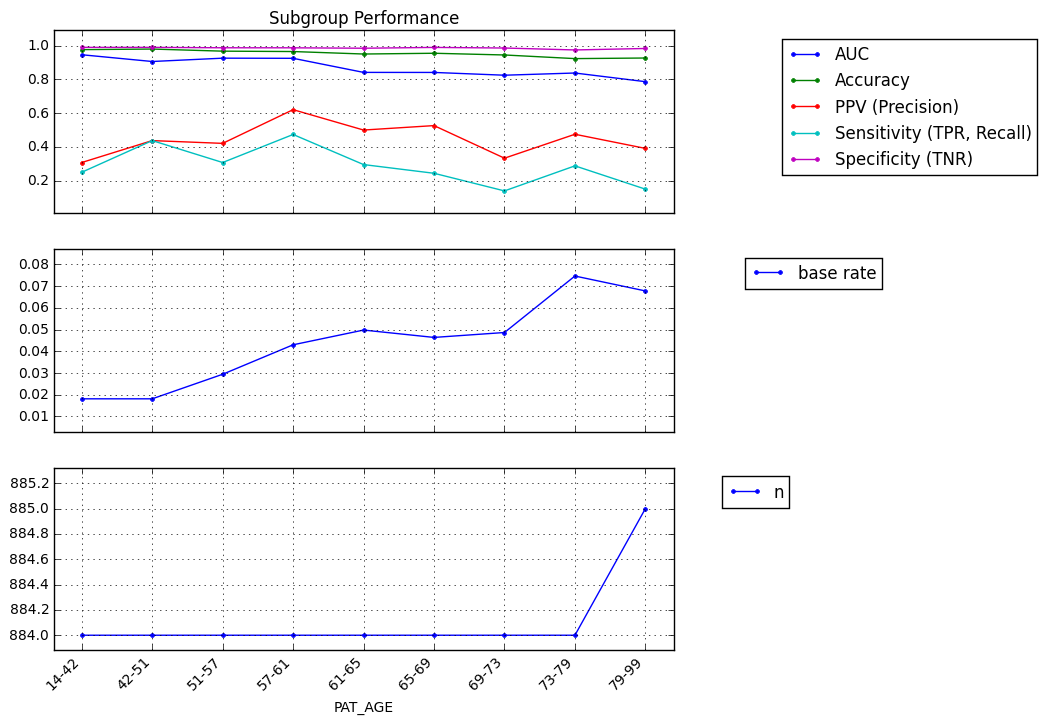

In [30]:
sp_age = run_numerical_subpop(test,'PAT_AGE',plot_output=False,thresh=0.3)
plt_subpop_perf(sp_age,xlabel='PAT_AGE');

## Logistic Regression

In [39]:
enc_data['SEX_C'].dtype

dtype('float64')

In [40]:
from sklearn.linear_model import LogisticRegression

in_vars = dx_cols + num_cols + cat_cols + ['PAT_AGE','SEX_C']

in_vars = [c for c in in_vars if (': count' not in c) and \
           (': std' not in c) and \
           (': prop STAT ordered' not in c)]

### Normalize ###
no_log_list = ['PAT_AGE','SEX_C'] + num_cols
no_norm_list = []
train_norm = train.copy()
test_norm = test.copy()
norm_dict = {}
for v in in_vars:
    if v not in no_norm_list:
        if v not in no_log_list:
            norm_dict[v+' mean'] = np.log(train[v]+1).mean()
            norm_dict[v+' std'] = np.log(train[v]+1).std()
            train_norm[v] = (np.log(train[v]+1) - norm_dict[v+' mean']) / norm_dict[v+' std']
            test_norm[v] = (np.log(test[v]+1) - norm_dict[v+' mean']) / norm_dict[v+' std']
        else:
            norm_dict[v+' mean'] = train[v].mean()
            norm_dict[v+' std'] = train[v].std()
            train_norm[v] = (train[v] - norm_dict[v+' mean']) / norm_dict[v+' std']
            test_norm[v] = (test[v] - norm_dict[v+' mean']) / norm_dict[v+' std']
    else:
        train_norm[v] = train[v]*1.0
        test_norm[v] = test[v]*1.0

In [41]:
train_norm['intercept'] = 1
test_norm['intercept'] = 1

In [42]:
last_labs = [c for c in train_norm if ': last' in c]
dx_hist = [c for c in train_norm if 'n_' in c]


In [43]:
import statsmodels.api as sm
in_vars_lr = ['intercept'] +  last_labs + dx_hist + ['PAT_AGE','SEX_C']

In [44]:
## Iterative variable selectionn
last_n_vars = 0
while len(in_vars_lr) != last_n_vars:
    last_n_vars = len(in_vars_lr)
    print(last_n_vars)
    logit = sm.Logit(train_norm[label_name],train_norm[in_vars_lr])
    result = logit.fit()
    in_vars_lr = result.pvalues.index[result.pvalues < 0.1]
    
print(result.summary())

165
Optimization terminated successfully.
         Current function value: 0.117934
         Iterations 14
39
Optimization terminated successfully.
         Current function value: 0.124342
         Iterations 9
36
Optimization terminated successfully.
         Current function value: 0.124469
         Iterations 9
35
Optimization terminated successfully.
         Current function value: 0.124520
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:                18567
Model:                          Logit   Df Residuals:                    18532
Method:                           MLE   Df Model:                           34
Date:                Fri, 05 Apr 2019   Pseudo R-squ.:                  0.2369
Time:                        14:36:35   Log-Likelihood:                -2312.0
converged:                       True   LL-Null:                       -3029.7
                         

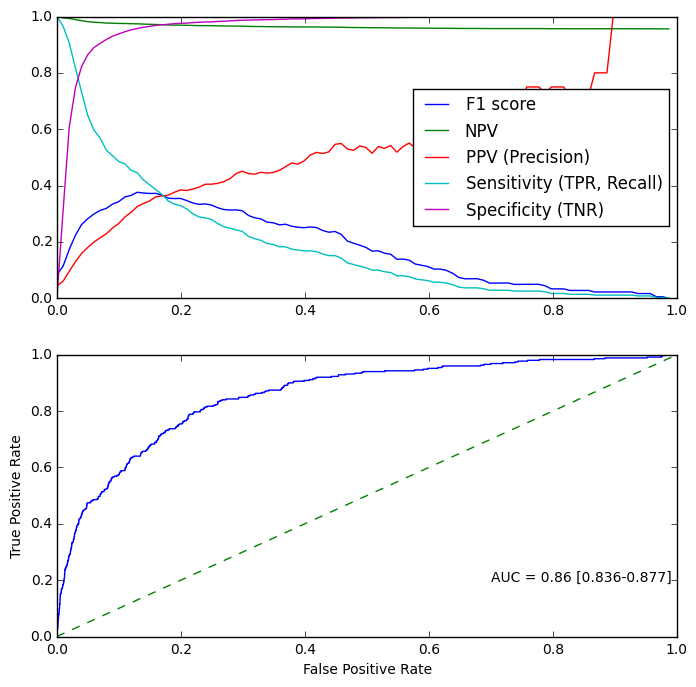

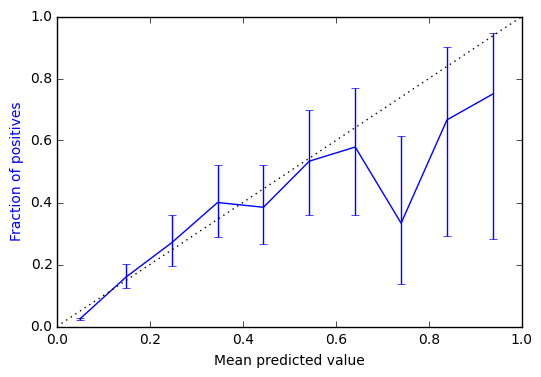

In [45]:
importances, ms_df = plot_perf(result, in_vars_lr, test_norm, logistic=True)

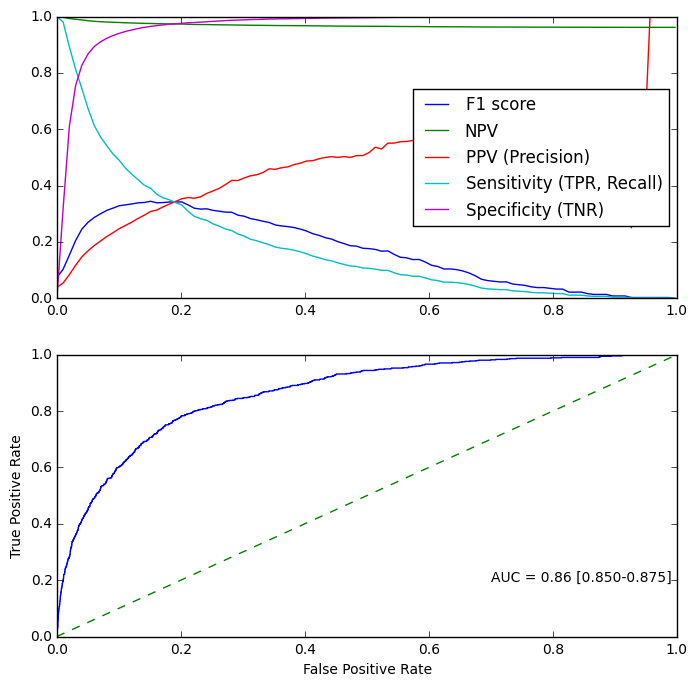

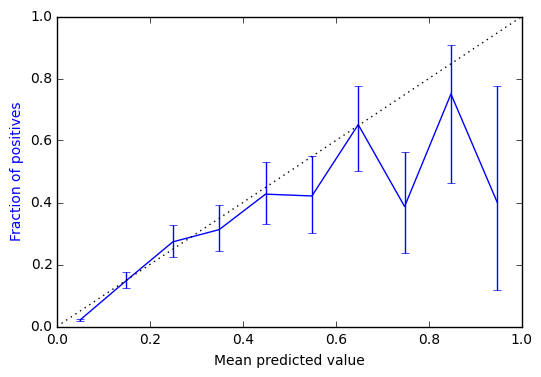

In [46]:
importances, ms_df = plot_perf(result, in_vars_lr, train_norm, logistic=True)

In [47]:
ms_df[(ms_df['threshold'] > 0.3) &(ms_df['threshold']<0.33)]

,Accuracy,Alert Rate,F1 score,FNR,FPR,NPV,PPV (Precision),"Sensitivity (TPR, Recall)",Specificity (TNR),base rate,confusion_matrix,n,threshold
30,0.958582,0.019928,0.291244,0.779021,0.011875,0.969391,0.427027,0.220979,0.988125,0.038509,"[[17640, 212], [557, 158]]",18567,0.302113
31,0.959067,0.018581,0.283019,0.790210,0.010923,0.968994,0.434783,0.209790,0.989077,0.038509,"[[17657, 195], [565, 150]]",18567,0.312183
32,0.959283,0.017935,0.278626,0.795804,0.010475,0.968795,0.438438,0.204196,0.989525,0.038509,"[[17665, 187], [569, 146]]",18567,0.322254


In [48]:
## LR "Importance" & direction
pv = pd.DataFrame(result.pvalues).sort(0)
pd.DataFrame(result.tvalues[pv.index])

,0
intercept,-65.132062
Albumin: last,-10.250277
n_Tumor_recent,10.022118
n_METS_recent,8.525422
PAT_AGE,8.389282
Alkaline Phosphatase: last,5.621641
SEX_C,5.547985
n_Tumor,-5.059770
n_BLA,5.026847
Red Blood Cells: last,-5.004892
